In [5]:
## Import packages

using Statistics
using Pkg
using LinearAlgebra
using StatsBase
using Random
using JLD
using Plots
using Distributions
using JSON
using MAT
Pkg.add("ColorSchemes")
using ColorSchemes
Pkg.add("PyCall")
using PyCall
nx = pyimport("networkx")
np = pyimport("numpy")

include("helper_functions.jl")

 Resolving package versions...
  Updating `/opt/julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `/opt/julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]


triu_elements (generic function with 1 method)

In [41]:
dsi_mat_dict = matread("../data/HCP/dsi_matrices.mat")
dsi_counts = dsi_mat_dict["ls234_count"]
unique(sort([dsi_counts...]))
nReps = size(dsi_counts)[3]

noise_mat = rand(Float64, size(dsi_counts))
dsi_noisy = dsi_counts.+noise_mat

# Now all noise will be those edges with weight <1
# Now all noise will be those edges with weight <1
for rep in collect(1:nReps)
    G_i = dsi_noisy[:,:,rep]
    G_i[diagind(G_i)] .=0
    dsi_noisy[:,:, rep] .= G_i
end

In [40]:
dsi_mat_dict


Dict{String,Any} with 3 entries:
  "ls234_qa"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.2…
  "ls234_count" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 424…
  "sbj_id"      => Any["100307"; "100408"; … ; "857263"; "899885"]

In [6]:
# Define parameters

# Read from config file
config_file = "config091720.json"
config = read_config("$(homedir())/configs/$(config_file)")

const NNODES = config["NNODES"]
const MAXDIM = config["MAXDIM"]
const NREPS = config["NREPS"]
const DATE_STRING = config["DATE_STRING"]
const SAVETAIL = config["SAVETAIL_graphInfo"]
const read_dir = "$(homedir())/$(config["read_dir_graphs"])/$(NNODES)nodes"
const save_dir = "$(homedir())/$(config["save_dir_forJason"])/$(NNODES)nodes"

# Locate graph files
graph_files = filter(x->occursin(DATE_STRING,x), readdir(read_dir))
println("Located the following graph files:")
for graph_file in graph_files
    println(graph_file)
end
model_names = [split(graph_file,"_")[1] for graph_file in graph_files]

Located the following graph files:
IID_70nodes_100reps_091720_graphs.jld
assortative_70nodes_100reps_20_5_10_5_091720_graphs.jld
coreperiphery_70nodes_100reps_15_5_10_5_091720_graphs.jld
cosineGeometric_70nodes_100reps_3_091720_graphs.jld
disassortative_70nodes_100reps_20_5_10_5_091720_graphs.jld
discreteUniformConf_70nodes_100reps_0_1000_091720_graphs.jld
dotProduct_70nodes_100reps_3_091720_graphs.jld
geometricConf_70nodes_100reps_001_100_091720_graphs.jld
probTriangle0_70nodes_100reps_0_091720_graphs.jld
probTriangle1_70nodes_100reps_01_091720_graphs.jld
probTriangle2_70nodes_100reps_02_091720_graphs.jld
probTriangle3_70nodes_100reps_03_091720_graphs.jld
probTriangle4_70nodes_100reps_04_091720_graphs.jld
probTriangle5_70nodes_100reps_05_091720_graphs.jld
probTriangle6_70nodes_100reps_06_091720_graphs.jld
probTriangle7_70nodes_100reps_07_091720_graphs.jld
probTriangle8_70nodes_100reps_08_091720_graphs.jld
probTriangle91_70nodes_100reps_091_091720_graphs.jld
probTriangle92_70nodes_100r

32-element Array{SubString{String},1}:
 "IID"                
 "assortative"        
 "coreperiphery"      
 "cosineGeometric"    
 "disassortative"     
 "discreteUniformConf"
 "dotProduct"         
 "geometricConf"      
 "probTriangle0"      
 "probTriangle1"      
 "probTriangle2"      
 "probTriangle3"      
 "probTriangle4"      
 ⋮                    
 "probTriangle94"     
 "probTriangle95"     
 "probTriangle96"     
 "probTriangle97"     
 "probTriangle98"     
 "probTriangle99"     
 "probTriangle9"      
 "probTriangle"       
 "randomGeom"         
 "ringLattice"        
 "rmsd"               
 "sqdEuclidean"       

In [10]:
graph_dict = load("$(read_dir)/randomGeom_70nodes_100reps_3_091720_graphs.jld")
weighted_graph_array = graph_dict["weighted_graph_array"]

nReps = size(weighted_graph_array)[3]
G_end = weighted_graph_array[:,:,nReps]

# Run PH

G_n = G_end
for n = 1:10
    # Sort nodes by strength
    G_strength = dropdims(sum(G_n, dims=1), dims=1)
    println(size(G_n))
    println(sum(G_strength))
    sorted_nodes = sortperm(G_strength, rev=true)
    highest_deg = sorted_nodes[1]
    println(G_strength[highest_deg])
    G_smaller = G_n[1:end .!= highest_deg, 1:end .!= highest_deg]
    println(size(G_smaller))

    # Run and save ph

    G_n = deepcopy(G_smaller)
end


(70, 70)
9304.175139708794
177.08688696515543
(69, 69)
(69, 69)
8950.001365778486
159.9845307837411
(68, 68)
(68, 68)
8630.032304211003
155.77720925359873
(67, 67)
(67, 67)
8318.477885703804
149.49959794799645
(66, 66)
(66, 66)
8019.478689807812
146.11470918932292
(65, 65)
(65, 65)
7727.2492714291675
139.50942964268236
(64, 64)
(64, 64)
7448.2304121438
136.62226652898408
(63, 63)
(63, 63)
7174.985879085832
133.73938364805738
(62, 62)
(62, 62)
6907.50711178972
129.2750080349577
(61, 61)
(61, 61)
6648.957095719802
125.3822697280685
(60, 60)


In [7]:
plot_array = Any[]

for graph_file in graph_files
    
    graph_dict = load("$(read_dir)/$(graph_file)")
    weighted_graph_array = graph_dict["weighted_graph_array"]

    nReps = size(weighted_graph_array)[3]
    G_end = weighted_graph_array[:,:,nReps]
    G_avg = dropdims(mean(weighted_graph_array, dims=3), dims=3)

    p1a = heatmap(G_end,yflip = true, aspect_ratio=:equal, grid = false, c = :viridis)
    title!("Last graph")
    ylabel!("Nodes")
    xlabel!("Nodes")
    
    # Degree distributions
    p1b = histogram([sum(G_end, dims=1)...], legend = false, c=:gray, alpha = 0.3)
    title!("Strength distribution last graph")
    ylabel!("Frequency")
    xlabel!("Node strength")


    # Edge weight distributions
    p1c = histogram([G_end...], legend = false, c=:gray, alpha = 0.3)
    title!("Last graph edge weight distribution")
    ylabel!("Frequency")
    xlabel!("Edge weight")
    
    
    p1d = heatmap(G_avg,yflip = true, aspect_ratio=:equal, grid=false, c = :viridis)
    title!("Average graph")
    ylabel!("Nodes")
    xlabel!("Nodes")
    
    p1e = histogram([sum(weighted_graph_array, dims=1)...], legend = false, c=:gray, alpha = 0.3)
    title!("Strength distribution all graphs")
    ylabel!("Frequency")
    xlabel!("Node strength")

    p1f = histogram([weighted_graph_array...], legend = false, c=:gray, alpha = 0.3)
    title!("All graphs edge weight distribution")
    ylabel!("Frequency")
    xlabel!("Edge weight")


    # Graph metrics
    clustering = zeros(1,nReps)
    modularity = zeros(1,nReps)


    for rep in 1:nReps

        g = nx.from_numpy_matrix(weighted_graph_array[:,:,rep], parallel_edges=false)
        clustering[1, rep] = nx.average_clustering(g, weight = "weight")
        modularity[1, rep] = nx.algorithms.community.modularity(g, nx.algorithms.community.label_propagation_communities(g))

    end


    p1g = histogram([clustering...], legend=false, c=:gray, alpha = 0.3)
    title!("Average clustering (all graphs)")
    xlabel!("Avg. clustering")
    ylabel!("Frequency")

    p1h = histogram([modularity...], legend=false, c=:gray, alpha = 0.3)
    title!("Modularity (all graphs)")
    xlabel!("Modularity")
    ylabel!("Frequency")


    pi = plot(p1a, p1b, p1c, layout = (3, 1))
#         pi = plot(p1a, p1b, p1c, p1d, p1e, p1f, p1g, p1h, layout = (8, 1))
#     savefig("../figures/$(replace(graph_file, "_graphs.jld" => ""))_$(SAVETAIL).pdf")
    push!(plot_array,pi)
end

plot(plot_array..., layout = (1,17), size = (1700, 5000))

InterruptException: InterruptException:

Plotting thresholded graphs

In [16]:
## Make a big plot of graphs for each
const read_dir_thresh = "$(homedir())/$(config["read_dir_thresh"])/$(NNODES)nodes"

# Maybe just betti bar first

# Filter to just the thresholds

thresh_files = filter(x->occursin("thresh",x), readdir(read_dir_thresh))
thresh_files = filter(x->occursin("$(DATE_STRING)",x), thresh_files)
thresh_files = filter(x->!occursin("noiseOnly",x), thresh_files)

# Locate the thresh nametages
thresh_nametags = []
for thresh_file in thresh_files
    tag = split(split(thresh_file, "graphs_")[2], "_edge")[1]
    thresh_nametags = [thresh_nametags; tag]
end

thresh_files

0-element Array{String,1}

In [13]:
## Loop through and make big graph

for thresh_nametag in thresh_nametags
    
    thresh_files_filtered = filter(x->occursin(thresh_nametag,x), thresh_files)
    
    for thresh_file_filtered in thresh_files_filtered
        
        # read in graphs
        graph_dict = load("$(read_dir)/$(thresh_file_filtered)")
        weighted_graph_array = graph_dict["weighted_graph_array"]

        nReps = size(weighted_graph_array)[3]
        G_end = weighted_graph_array[:,:,nReps]
        
        # Convert to networkx graph
        g = nx.from_numpy_matrix(G_end, parallel_edges=false)
        nx.draw_networkx(g)
        
    end
    
end

        
        

ErrorException: File /home/jovyan/processed_data/graphs/70nodes/IID_70nodes_50reps_091520_graphs_thresh02_edge483.jld cannot be found

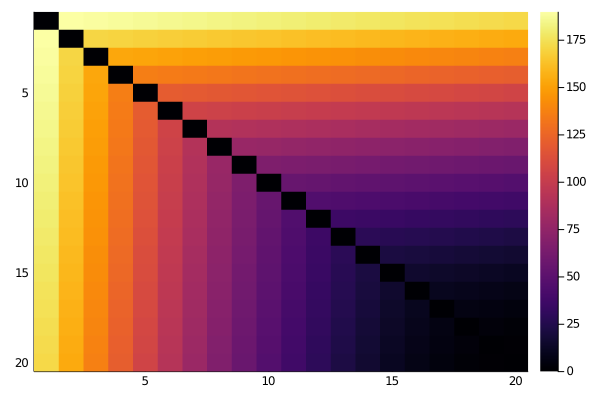

In [71]:
### Making giant star graph

adj = zeros(20,20)
nEdges = binomial(20,2)
nNodes = 20

for i=1:nNodes
    for j = (i+1):nNodes
        adj[i,j] = nEdges
        adj[j,i] = nEdges
        nEdges = nEdges-1
    end
end
    
heatmap(adj, yflip=true)
        


In [55]:
adj = zeros(20,20)
ne = binomial(20,2)

sample(collect(1:nNodes),k,replace=false)

4-element Array{Int64,1}:
 15
 10
 18
  5

In [67]:
deleteat!(collect(1:nNodes),2)

19-element Array{Int64,1}:
  1
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20